# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Motivation : Occams Razor
Suppose that we have a data X, and we have two trained models M1 & M2, where M1 is a very complex model with requires high computation and gives you good performance and M2 is a very simple model with less computation and has a performance close to M1, then according to Occam Razor we should prefer to use model M2 i.e. the simplest model.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import cv2
import tensorflow as tf
import numpy as np
import random
import math
import csv
# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

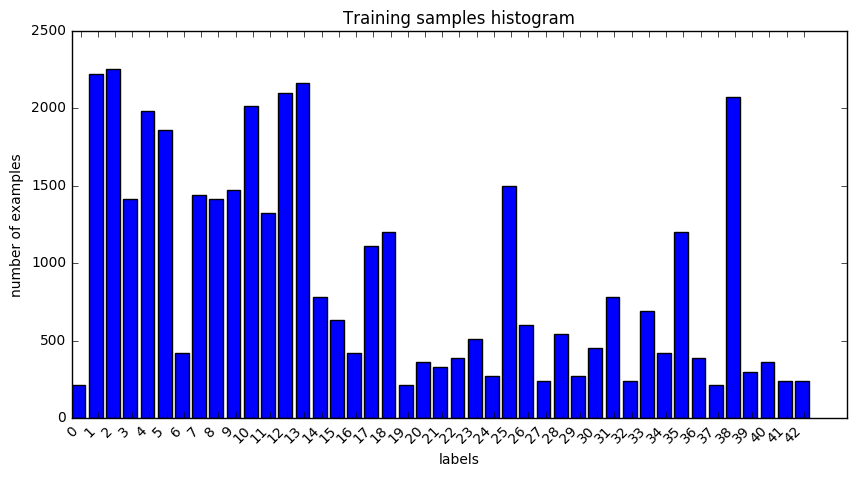

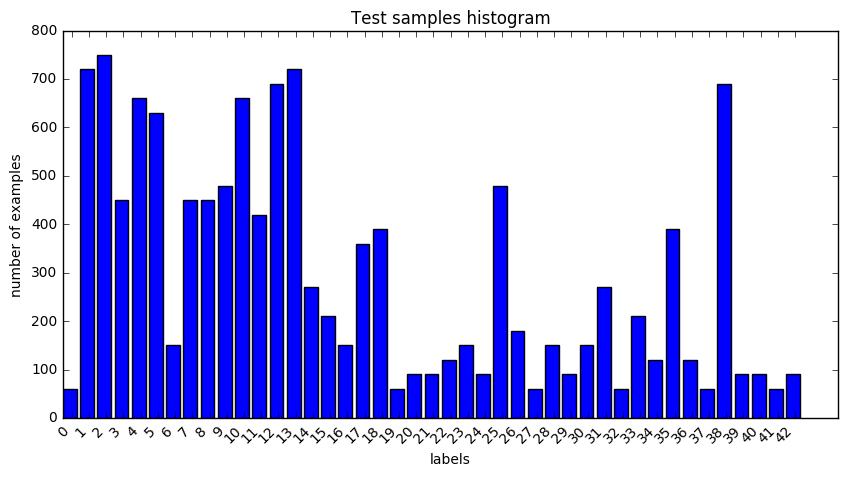

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
# Counting the number of occurences of each label in the training dataset
def plot_class_frequencies(labels, title): 
    unique_labels = list(range(0,43))
    class_frequency = [0]*len(unique_labels)
    for l in labels:
        class_frequency[l] = class_frequency[l] + 1            
 
    fig, ax = plt.subplots(figsize=(10, 5))

    bars = plt.bar(range(n_classes), class_frequency, width=0.8, label=unique_labels)
    xticks_pos = [0.65*b.get_width() + b.get_xy()[0] for b in bars]
    plt.xticks(xticks_pos, unique_labels,  ha='right', rotation=45)
    plt.ylabel('number of examples')
    plt.xlabel('labels')    
    plt.title(title)

    plt.show()

# Plot the histograms for both the training set and the test set to visualize whether there are skewed classes and
# whether each class is represented moreless equally in both data sets.

plot_class_frequencies(y_train, 'Training samples histogram')
plot_class_frequencies(y_test, 'Test samples histogram')

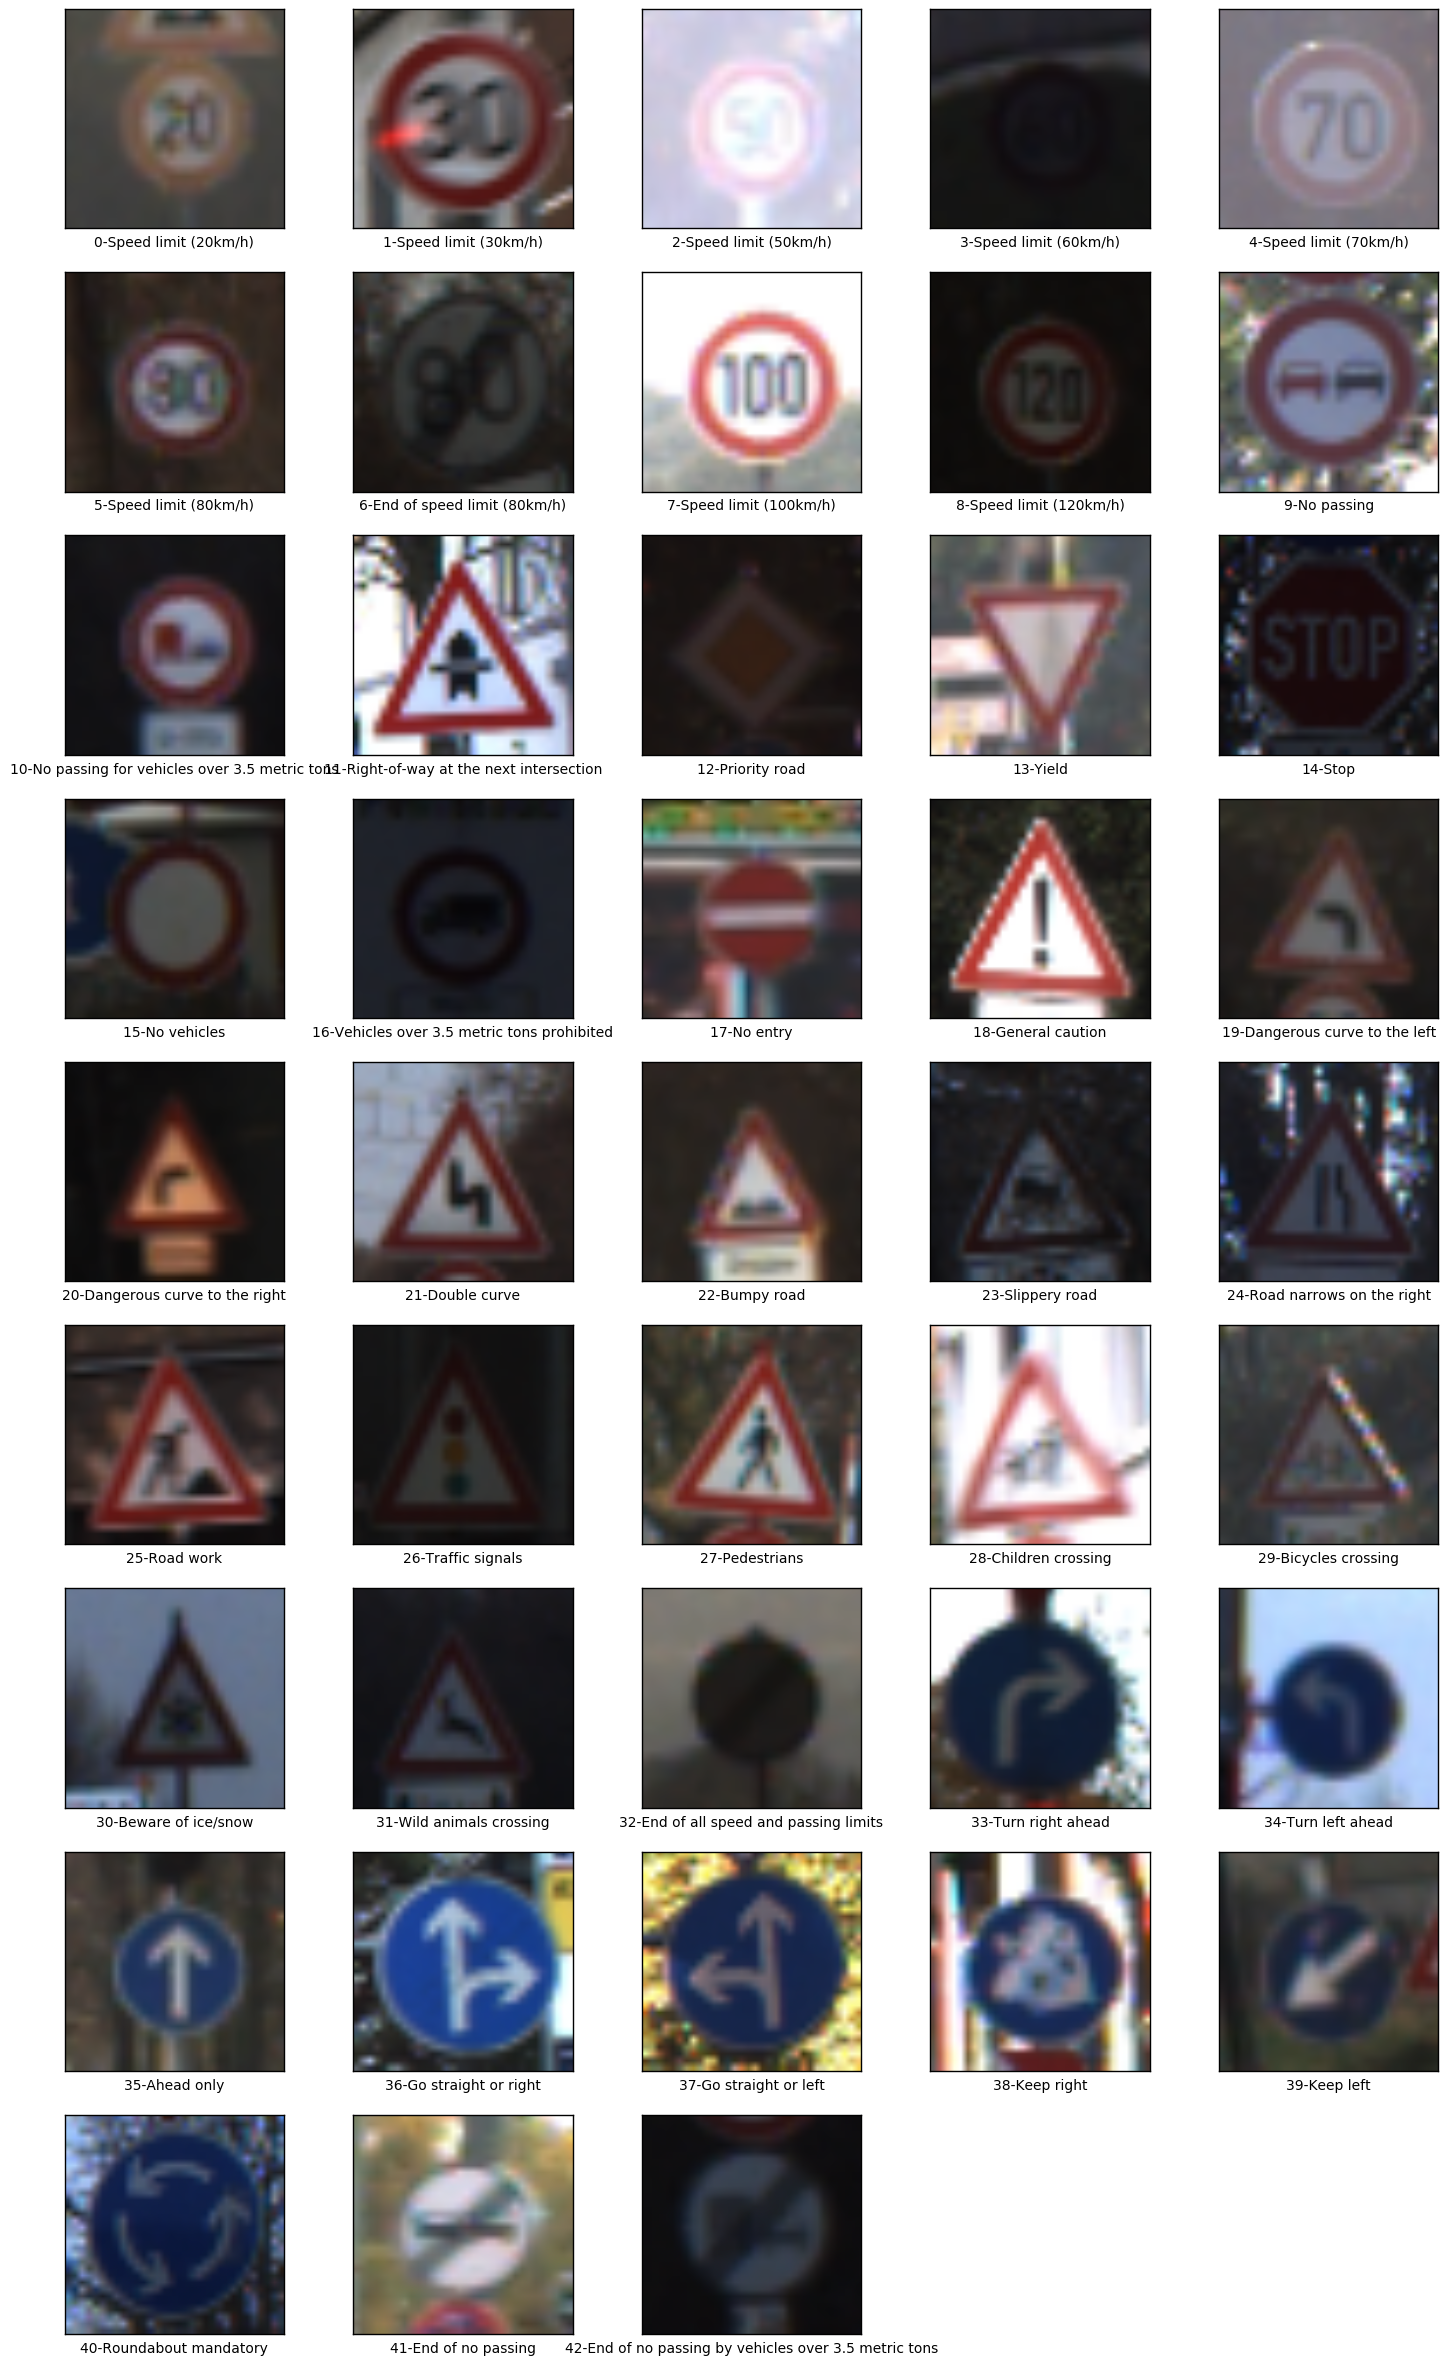

In [4]:
signnames_file = "signnames.csv"
with open(signnames_file, mode='r') as f:
    signnames = []
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        signnames.append(row['SignName'])
def plot_image_classes():
    unique_labels = list(range(0,43))

    cols = 5
    rows = math.ceil(len(unique_labels)/cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 30))

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    while unique_labels:
        i = unique_labels.pop()
        ax = axes[i//cols][i%cols]
        labels_subset = [j for j,l in enumerate(y_train) if l==i]
        ax.imshow(X_train[labels_subset[int(len(labels_subset)*random.random())]])
        ax.set_xlabel("{}-{}".format(i, signnames[i]))

    for ax in axes.flat:
        if ax.get_xlabel():
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)
            
    plt.show()
    
plot_image_classes()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
from skimage import color
from sklearn.preprocessing import scale
X_train, y_train = shuffle(X_train, y_train, random_state = 42)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer: Following the Occams Razor principle, I tried to make the model as simple as possible, with very little pre-processing and computation. I just used shuffle from scikit learn library to shuffle the data**

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                stratify=y_train, 
                                                                random_state=42)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:I used the test set as it is from the dataset provided. But the training set that has been provided was splitted into training and validation sets using train_test_split from scikit learn library and split ratio is 80:20**

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):
    mu = 0
    sigma = 0.02
    
    # layer 1 - convolution, Input = 32x32x3, Output = 28x28x32
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_B = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.bias_add(tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID'), conv1_B)
    
    # layer 1 - activation
    conv1 = tf.nn.relu(conv1)
    
    # layer 1 - max pooling, Input = 28x28x32, Output = 14x14x32
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 2 - convolution, Input = 14x14x32, Output = 12x12x128
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 128), mean = mu, stddev = sigma))
    conv2_B = tf.Variable(tf.zeros(128))
    conv2 = tf.nn.bias_add(tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'), conv2_B)
    
    # layer 2 - activation
    conv2 = tf.nn.relu(conv2)
    
    # layer 2 - max pooling, Input = 12x12x128, Output = 6x6x128
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 3 - convolution, Input = 6x6x128, Output = 4x4x256
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 256), mean = mu, stddev = sigma))
    conv3_B = tf.Variable(tf.zeros(256))
    conv3 = tf.nn.bias_add(tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID'), conv3_B)
    
    # layer 3 - activation
    conv3 = tf.nn.relu(conv3)
    
    # layer 3 - max pooling, Input = 4x4x256, Output = 2x2x256
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # flatten, Input = 2x2x256, Output = 1024
    fc = flatten(conv3)
    
    # layer 4 - fully connected 1, Input = 1024, Output = 256
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 256), mean = mu, stddev = sigma))
    fc1_B = tf.Variable(tf.zeros(256))
    fc1 = tf.matmul(fc, fc1_W) + fc1_B
    
    # layer 4 - activation
    fc1 = tf.nn.relu(fc1)
    
    # dropout - to avoid overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # layer 5 = fully connected 2, Input = 512, Ouptut = 128
    #fc2_W = tf.Variable(tf.truncated_normal(shape=(512, 128), mean = mu, stddev = sigma))
    #fc2_B = tf.Variable(tf.zeros(128))
    #fc2 = tf.matmul(fc1, fc2_W) + fc2_B
    
    # layer 5 - activation
    #fc2 = tf.nn.relu(fc2)
    
    # dropout - to avoid overfitting
    #fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # layer 5 = fully connected 2, Input = 256, Output = 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_B = tf.Variable(tf.zeros(43))
    #logits = tf.nn.softmax(tf.matmul(fc1, fc3_W) + fc3_B)
    logits = tf.matmul(fc1, fc3_W) + fc3_B
        
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:The CNN model has 5 layers and is described as below:**

Layer 1 (Input Layer): Convolution, Input: 32x32x3, Output: 28x28x32, Filter: 5x5, Strides: 1x1x1x1, Padding: VALID Relu activation Max Pooling, Input: 28x28x32, Output: 14x14x32, Strides: 1x2x2x1, Padding: VALID

Layer 2: Convolution, Input: 14x14x32, Output: 12x12x128, Filter: 3x3, Strides: 1x1x1x1, Padding: VALID Relu activation Max Pooling, Input: 12x12x128, Output: 6x6x128, Strides: 1x2x2x1, Padding: VALID

Layer 3: Convolution, Input: 6x6x128, Output: 4x4x256, Filter: 3x3, Strides: 1x1x1x1, Padding: VALID Relu activation Max Pooling, Input: 4x4x256, Output: 2x2x256, Strides: 1x2x2x1, Padding: VALID

Layer 4: Fully Connected, Input: 1024, Output: 256 Relu activation Dropout layer to avoid overfitting

Layer 5 (Output Layer): Fully Connected, Input: 256, Output: 43

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 9
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # Dropout probability
one_hot_y = tf.one_hot(y, 43)

In [9]:
rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training .....\n")
    for i in range(0, EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y, keep_prob: 0.5})
        
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {}...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    save_file = './trained_model.ckpt'
    saver.save(sess, save_file)
    print("Model Saved\n")  

Training .....

EPOCH 1...
Validation Accuracy = 0.932

EPOCH 2...
Validation Accuracy = 0.974

EPOCH 3...
Validation Accuracy = 0.982

EPOCH 4...
Validation Accuracy = 0.989

EPOCH 5...
Validation Accuracy = 0.986

EPOCH 6...
Validation Accuracy = 0.984

EPOCH 7...
Validation Accuracy = 0.992

EPOCH 8...
Validation Accuracy = 0.994

EPOCH 9...
Validation Accuracy = 0.992

Model Saved



In [12]:
# test accuracy
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('trained_model.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    #X_test = PreProcess(X_test)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.957


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: AdamOptimizer

Batch size: 128

Stddev: 0.02. Chosen this because of (1 / sqrt(32 32 3))

Epochs: 9 (Since I want to make the model simple and computationally less expensive and also get the best performance while avoiding overfitting) **Occams Razor Priciple** .As we can see after 5 epoches there is not much improvement in validation accuracy, and the accuracy is almost constant, which is an early sign of over fitting. But as you train for more than 9 epoches the validation accuracy start falling slowly, which is an indication of overfitting. I experimented with that and decided that 9 epoches will be the best choice for this model, which allows the model to learn the required information while avoiding overfitting to the data, and also using less computational resources.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** According to my understanding depth(both network and layer) plays a key role in determining the performance of the model. So in order to find more features at each layer of the CNN, I choose the depth to be slightly higher, and I directly used the original raw image for training, used deeper network for training. At first I started with LeNet architecture and checked the performance of it and found that the model performance on the test set is around 85%, also I needed more epoches to get to decent validation accuracy. As, I mentioned earlier, to get the best out of the model, we need to increase the depth of the model, on the other hand we should be careful about overfitting. I'm not a fan of fully connected layers, because they are the main culprits in making the model complex ( i.e. the number of parameters involved in fully connected layers are very high when compared with convolution layers). So I decided to add one more convolution layers, and did some hyperparameter tweaking and got the best performance with which I'm satisfied. I follow the same process in my Deep Learning research to work with my own classification datasets, but there since the images are of high resolution , I start with AlexNet, and then do tranfer learning with Alexnet, if these two fails, I try to incrementally add more layers and increase the depth of the model. And this approach has given me good results on my datasets. (Dataset1: 6000 images, Dataset2: 25000 images) 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

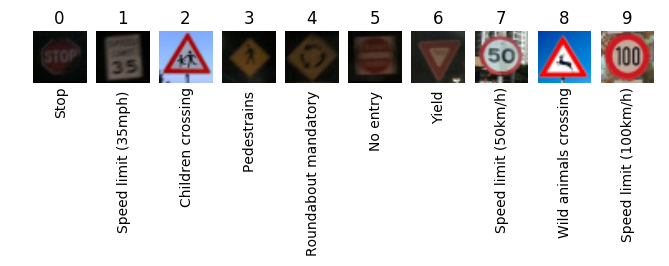

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

new_data_dir = 'new-data/'

n_new_images = 10
new_image_labels = ['Stop', 
                    'Speed limit (35mph) ',
                    'Children crossing',
                    'Pedestrains ',
                    'Roundabout mandatory ',
                    'No entry ',
                    'Yield ',
                    'Speed limit (50km/h)',
                    'Wild animals crossing',
                    'Speed limit (100km/h)'
                   ]
X_new = np.empty(shape=[0,32,32,3], dtype='uint8')

plt.figure(figsize=(8,1))

for i in range(n_new_images):
    
    new_img = mpimg.imread("new-data/" + str(i+1)+".PNG")[:,:,0:3]  # Only take the RGB channel
    new_img_scaled = cv2.resize(new_img, (32, 32), interpolation=cv2.INTER_AREA)  # Scale the image to 32x32
    plt.subplot(1,n_new_images,i+1)
    plt.imshow(new_img_scaled); plt.title(''); plt.axis('off')
    plt.text(12, 40, new_image_labels[i], rotation=90)
    plt.title(i)
    
    # Prepare the input data
    X_new = np.append(X_new, np.array([new_img_scaled]),axis=0)
    
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I have collected some random complex traffic sign images from internet. These signs have different sign colours and background compared to that of the training data set, which makes the them very difficult for the trained model to classify.

In [16]:
prediction = tf.argmax(logits, 1)

In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('trained_model.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    new_pred = sess.run(prediction, feed_dict={x: X_new, keep_prob: 1.0})
    
    print("Prediction: ", new_pred)

Prediction:  [13 13  5 13 13 13 13  5 25  5]


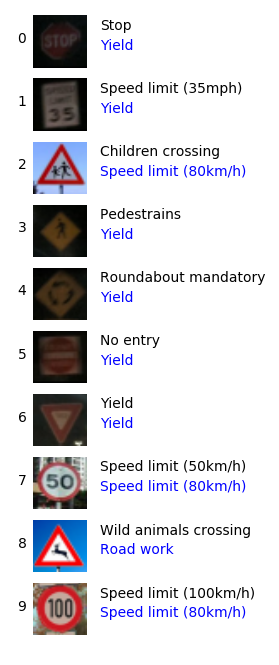

In [18]:
# Let's visualize the results
plt.figure(figsize=(8,8))

for i, sign_pred in enumerate(new_pred):
    plt.subplot(n_new_images,1,i+1)
    plt.imshow(X_new[i])
    plt.text(40, 8, new_image_labels[i], rotation=0)  # Ground truth is black
    plt.text(40, 20, signnames[sign_pred], rotation=0, color='b')  # Prediction is blue
    plt.text(-10, 16, i);
    plt.axis('off');
    
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 1 out of 10 images are predicted correctly on the new images. So the accuracy on the new images is 10% . Because of the variations in colour and background compared to training dataset, it was not able to perform well on this images. Also algorithm was able to recognise speed limit sign, but fails to exactly identify how much is the speed limit.

In [30]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('trained_model.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: X_new, keep_prob: 1.0})
    #print(top_k)

In [31]:
# Let's check the top_k data
np.set_printoptions(suppress=True, precision=3)
print(top_k.values[0])
print(top_k.indices[0])

[ 0.085  0.072  0.056  0.055  0.053]
[13  5 25  8 26]


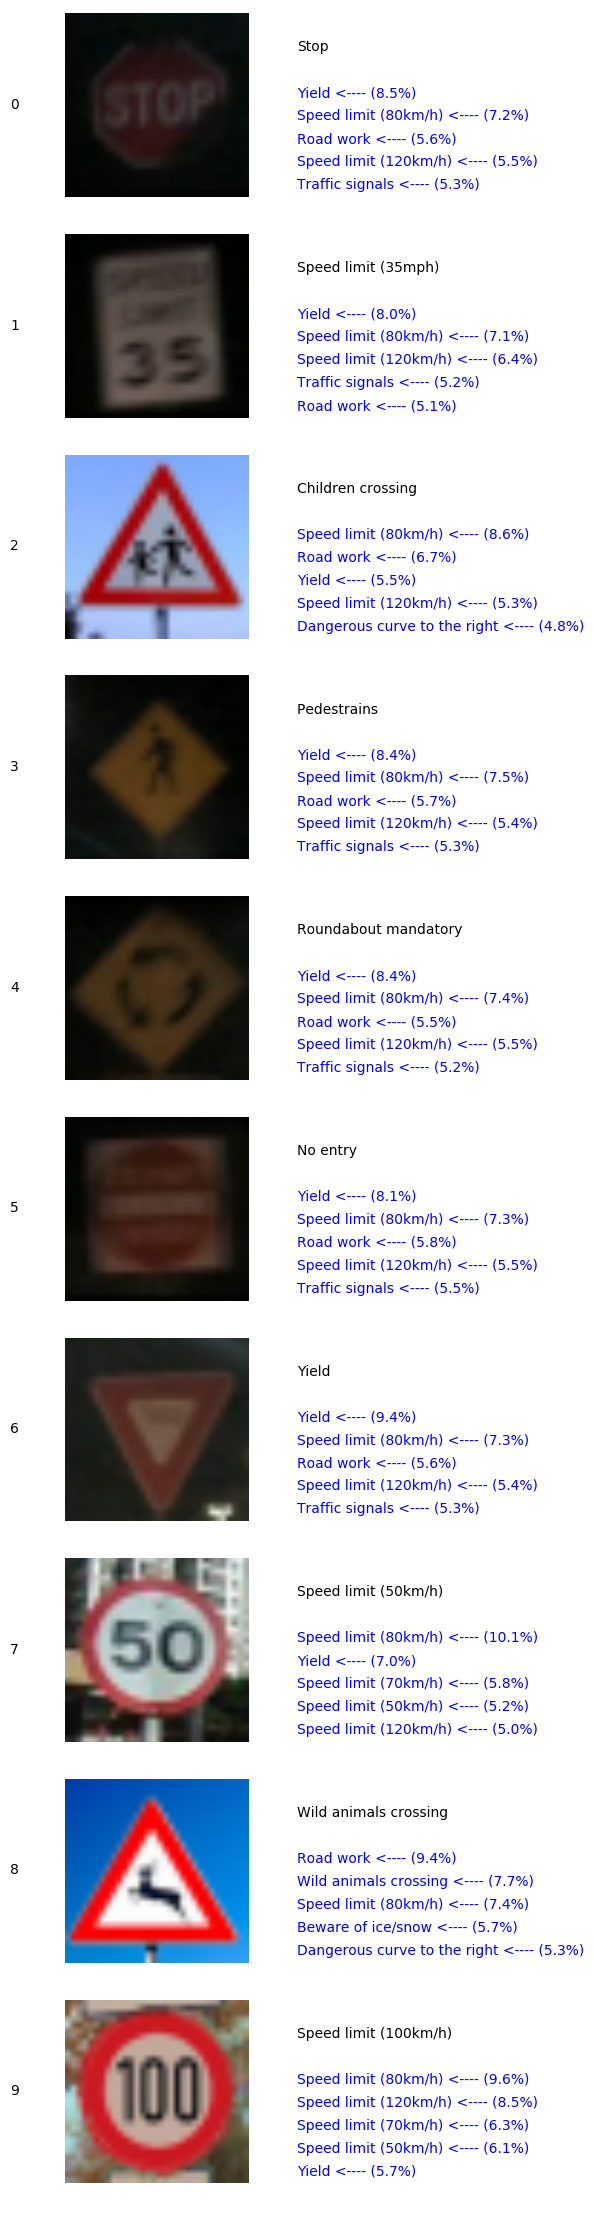

In [34]:
# Let's visualize the results
plt.figure(figsize=(28,28))

for i, sign_pred in enumerate(new_pred):
    
    plt.subplot(n_new_images,1,i+1)
    plt.imshow(X_new[i])
    
    plt.text(40, 6, new_image_labels[i], rotation=0)  # Ground truth is black
    
    y_position = 14
    for prob, idx in zip(top_k.values[i], top_k.indices[i]):
        pred_info = signnames[idx] + ' <---- (' + str(np.round(prob*100, 1)) + '%)'
        plt.text(40, y_position, pred_info, rotation=0, color='b')  # Prediction is blue
        y_position += 4
    
    plt.text(-10, 16, i);
    
    plt.axis('off');
    
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

The softmax probabilities for top 5 predictions are visualised along with the ground truth. The top 5 accuracy was 20% . We can notice that the confidence of the predictions (i.e. the softmax probabilities are less, this is because of the difference in color, background and some completly different shape of the signs when compared with the original dataset. For most of the signs that are in triangular shape with red color,the model is predicting them as yield sign as top prediction( because these signs are similar to the yield sign in terms of colour when compared with original dataset. If we notice the speed limit signs, the model was able to recognise them as speed limit signs, but again fails to exactly identify how much is the speed limit, this is revealed using the top 5 predictions. For some of the signs, the correct prediction appreared in the top-5 when compared with incorrect top-1 prediction.